In [13]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Carregar dados (primeiras 500 amostras)
X_train = np.load('../../iot-ids-research/data/processed/binary/X_train_binary.npy')[:500]
print(f"Shape dos dados: {X_train.shape}")

Shape dos dados: (500, 39)


In [17]:
# 2. Rodar K-means
# TODO: Criar KMeans com n_clusters=2
# TODO: Fazer fit_predict para obter os labels
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(X_train)


In [18]:
# 3. Reduzir para 2D com PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

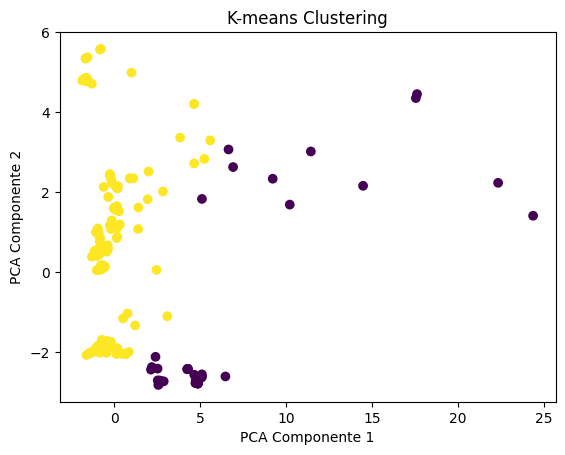

In [21]:
# 4. Visualizar
# TODO: Usar plt.scatter com X_2d[:, 0], X_2d[:, 1] e colorir por labels
# TODO: Adicionar título e mostrar o plot
plt.title('K-means Clustering')
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)

In [26]:
#1. Os 2 clusters ficaram bem separados no plot? Ou estão misturados/sobrepostos?
#Sim, os 2 clusters ficaram bem separados no plot.
#2. Quantos pontos foram atribuídos a cada cluster? (Você pode verificar com np.bincount(labels))
points_per_cluster = np.bincount(labels)
print(f"Pontos por cluster: {points_per_cluster}")

#3. Você sabe os labels reais (normal vs attack)? Se carregar y_train_binary.npy, consegue comparar se K-means acertou a separação?
y_train_binary = np.load('../../iot-ids-research/data/processed/binary/y_train_binary.npy')[:500]

# O K-means não sabe qual cluster é "normal" e qual é "attack"
# Precisamos verificar qual mapeamento dá melhor resultado
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Testar mapeamento direto (0->0, 1->1)
accuracy_direct = accuracy_score(y_train_binary, labels)

# Testar mapeamento invertido (0->1, 1->0)
labels_inverted = 1 - labels
accuracy_inverted = accuracy_score(y_train_binary, labels_inverted)

# Escolher o melhor mapeamento
if accuracy_direct >= accuracy_inverted:
    labels_mapped = labels
    accuracy = accuracy_direct
    print(f"Usando mapeamento direto (cluster 0 -> label 0, cluster 1 -> label 1)")
else:
    labels_mapped = labels_inverted
    accuracy = accuracy_inverted
    print(f"Usando mapeamento invertido (cluster 0 -> label 1, cluster 1 -> label 0)")

print(f"\n{'='*50}")
print(f"ANÁLISE DE COMPARAÇÃO K-MEANS vs LABELS REAIS")
print(f"{'='*50}")
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Matriz de confusão
cm = confusion_matrix(y_train_binary, labels_mapped)
print(f"\nMatriz de Confusão:")
print(f"                Predito")
print(f"              Normal  Attack")
print(f"Real Normal    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"     Attack    {cm[1,0]:5d}  {cm[1,1]:5d}")

# Métricas detalhadas
print(f"\nRelatório de Classificação:")
print(classification_report(y_train_binary, labels_mapped, 
                           target_names=['Normal', 'Attack']))

# Distribuição dos labels reais
real_distribution = np.bincount(y_train_binary)
print(f"\nDistribuição dos labels reais:")
print(f"  Normal (0): {real_distribution[0]} amostras")
print(f"  Attack (1): {real_distribution[1]} amostras")

print(f"\nDistribuição dos clusters K-means:")
print(f"  Cluster 0: {points_per_cluster[0]} amostras")
print(f"  Cluster 1: {points_per_cluster[1]} amostras")


Pontos por cluster: [ 44 456]
Usando mapeamento direto (cluster 0 -> label 0, cluster 1 -> label 1)

ANÁLISE DE COMPARAÇÃO K-MEANS vs LABELS REAIS

Accuracy: 0.9040 (90.40%)

Matriz de Confusão:
                Predito
              Normal  Attack
Real Normal        6     10
     Attack       38    446

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.14      0.38      0.20        16
      Attack       0.98      0.92      0.95       484

    accuracy                           0.90       500
   macro avg       0.56      0.65      0.57       500
weighted avg       0.95      0.90      0.92       500


Distribuição dos labels reais:
  Normal (0): 16 amostras
  Attack (1): 484 amostras

Distribuição dos clusters K-means:
  Cluster 0: 44 amostras
  Cluster 1: 456 amostras


📊 Análise do Seu Resultado

  O que K-means encontrou:
  - Cluster 0: 44 amostras (6 normais + 38 ataques)
  - Cluster 1: 456 amostras (10 normais + 446 ataques)

  O que isso significa:
  - K-means não separou normal de attack - ele encontrou outra estrutura nos dados
  - Os 44 pontos no cluster 0 são provavelmente um subtipo de ataque ou outliers, não tráfego normal
  - O recall de 0.38 para Normal mostra que K-means só "acertou" 6 de 16 normais

  ---
  ★ Insight ─────────────────────────────────────
  Por que K-means falhou aqui?

  1. Assume clusters de tamanho similar - K-means minimiza variância intra-cluster, tendendo a criar clusters balanceados. Com 16 vs 484, ele "ignora" a classe minoritária.
  2. Assume clusters esféricos - Se o tráfego normal não forma uma "bola" compacta no espaço de features, K-means não vai encontrá-lo.
  3. Não é supervisionado - K-means não sabe que você quer separar normal/attack. Ele encontra a estrutura mais "natural" dos dados, que pode ser outra coisa (tipos de ataque diferentes, por exemplo).

  Conexão com IDS real: Em produção, tráfego IoT também é desbalanceado - muito mais tráfego normal que ataques. Isso inverte o problema mas a lição é a mesma: K-means puro não é ideal para detecção de
  anomalias.

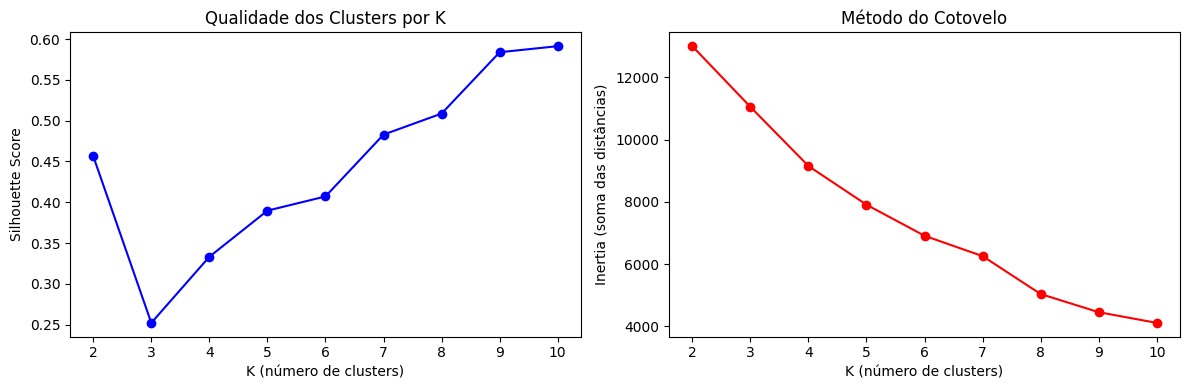

Melhor K pelo Silhouette: 10


In [29]:
from sklearn.metrics import silhouette_score

# Testar diferentes valores de K
k_values = range(2, 11)
silhouette_scores = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train)
    silhouette_scores.append(silhouette_score(X_train, labels))
    inertias.append(kmeans.inertia_)

# Plot Silhouette Score (maior = melhor separação)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('K (número de clusters)')
plt.ylabel('Silhouette Score')
plt.title('Qualidade dos Clusters por K')

# Plot Elbow (procurar "cotovelo")
plt.subplot(1, 2, 2)
plt.plot(k_values, inertias, 'ro-')
plt.xlabel('K (número de clusters)')
plt.ylabel('Inertia (soma das distâncias)')
plt.title('Método do Cotovelo')
plt.tight_layout()
plt.show()

print(f"Melhor K pelo Silhouette: {k_values[np.argmax(silhouette_scores)]}")

In [30]:
for k, inertia in zip(k_values, inertias):
    print(f"K={k:2d}: Inertia = {inertia:,.0f}")

K= 2: Inertia = 13,003
K= 3: Inertia = 11,053
K= 4: Inertia = 9,153
K= 5: Inertia = 7,910
K= 6: Inertia = 6,911
K= 7: Inertia = 6,258
K= 8: Inertia = 5,039
K= 9: Inertia = 4,456
K=10: Inertia = 4,113
